<a href="https://colab.research.google.com/github/ankit-kothari/stype_transfer/blob/master/pytorch_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvison
!pip install Pillow==4.0

ERROR: Could not find a version that satisfies the requirement torchvison (from versions: none)
ERROR: No matching distribution found for torchvison


In [ ]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np




*   VGG19 features portion is the CNN layers
*   keeping requires grad = False keeps the parameters unaffected during gradient decent and backpropogation
*   torch.device function to use GPU 
*   connect the model to the device





In [ ]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
  param.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

1.  unsqueeze adds an extra dimension (just like np.expand.dims)
2.  image is resized to the maximum (400 pixel this case) dimension
3.  image is normalized to mean=0.5 and stdv= 0.5
4.  image is converted to a tensor


In [ ]:
def load_image(img_path, max_size=600, shape=None):
  image = Image.open(img_path).convert('RGB')
  print(image.size)
  if max(image.size) > max_size:
    size = max_size
  else: 
    size = max(image.size)

  if shape is not None:
    size=shape

  in_transform= transforms.Compose([
       transforms.Resize(size),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), 
                                             (0.5, 0.5, 0.5))])
  image = in_transform(image).unsqueeze(0)
  print((image.size))
  return image


1.   load the images and converted into TENSOR
2.   pass in the shape parameter so as the two images are of the same size



In [ ]:
content = load_image('/content/drive/My Drive/images/dhonilh.jpeg').to(device)
style = load_image('/content/drive/My Drive/images/tiger.jpeg', shape=content.shape[-2:]).to(device)

(274, 184)
<built-in method size of Tensor object at 0x7f5bf4d6cbd0>
(236, 213)
<built-in method size of Tensor object at 0x7f5bf45497e0>


In [ ]:
style.shape[-2:]

torch.Size([274, 408])

Convert the images into numpy array



1.   Tensor passed in is in shape (batch_size, color channel, H, W)
2.   Clone before to converting to numpy array
3.   then squeeze the batch_size dimension
4.   Transpose the array in shape (H,W, color channel) for matplotlib
5.   denormalize the image
4.   Clip the image so that it is in 0 to 1 range



In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy()
    #print(image.shape)
    image = image.squeeze()
    #print(image.shape)
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 407.5, 273.5, -0.5)

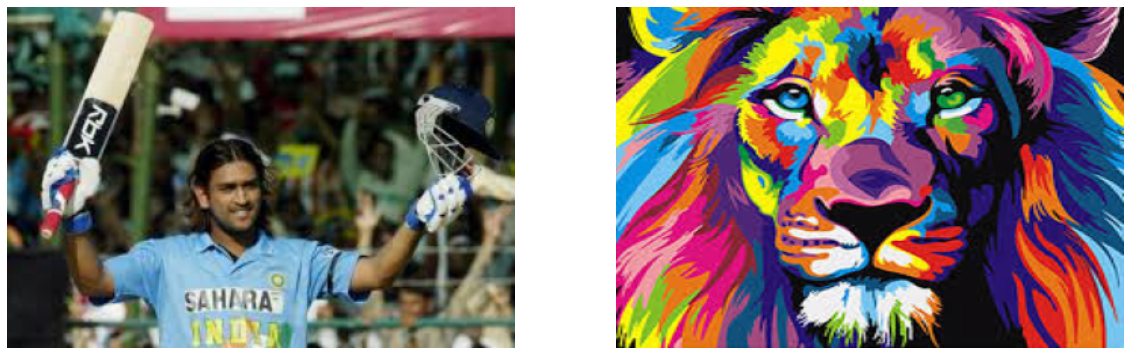

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

1.   Initializing the layers that will be used for content and style output
2.   Create a dictionary to store the output of the image at each layer
3. Create a feature dictionary for content image
4. Create a feature dictionary for style image


In [ ]:
def get_features(image, model):
   
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
        
    features = {}
    #print(image.shape)
    for name, layer in model._modules.items():
        image = layer(image)
        #print(image.shape)
        if name in layers:
            features[layers[name]] = image
            
    return features

In [ ]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [ ]:
content_features.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [ ]:
style_features.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

1.   Create a gram matrix function
2.   Loop in each output of the style features and create a gram matrix dictionary



In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [ ]:
style_grams = {layer:gram_matrix(style_features[layer]) for layer in style_features.keys()}

In [ ]:
style_grams['conv1_1']

tensor([[5.0375e+01, 1.5597e+02, 6.2197e-02,  ..., 4.0125e+00, 8.5257e+01,
         1.9639e+02],
        [1.5597e+02, 4.2813e+04, 1.3704e+02,  ..., 1.0012e+04, 1.1558e+04,
         3.0941e+04],
        [6.2197e-02, 1.3704e+02, 7.6848e+01,  ..., 0.0000e+00, 1.5790e+02,
         2.7412e+02],
        ...,
        [4.0125e+00, 1.0012e+04, 0.0000e+00,  ..., 3.0388e+04, 9.6494e+03,
         1.4123e+04],
        [8.5257e+01, 1.1558e+04, 1.5790e+02,  ..., 9.6494e+03, 2.1857e+04,
         1.5394e+04],
        [1.9639e+02, 3.0941e+04, 2.7412e+02,  ..., 1.4123e+04, 1.5394e+04,
         6.7769e+04]], device='cuda:0')

1. In style features earlier layers are more important than the later layers opposite of the content extraction
2. Ratio is set for each of the style layer outputs
3. also alpha/beta is the ratio of content_weight/style weigh can have a big affect on the final image transfer


In [ ]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta


1. Initializing the Input Image
2. This can be random noise for an image but we will be taking the clone of the content image
3. Using the requires_grad_(True) parameter to optimize the input image wrt to style and content images.

In [ ]:
input_image = content.clone().requires_grad_(True).to(device)


1. show_every = 300, to show our style transfer progress at every 300 steps.
2. Initializing the optimizer to optimize the input image
3. Run the optimization for 300 steps to get decent results

In [ ]:
show_every = 1000
optimizer = optim.Adam([input_image], lr=0.003)
steps = 6000

###This part of the process is for visualization purposes
1. Convert the input_image to numpy array and RGB
2. declare an image array to store 300 frames
3. declare a counter to capture a frame after every 7 images

In [ ]:
height, width, channels = im_convert(input_image).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0

##OPTIMIZATION PROCESS
1. Create a loop  to optimize for "steps" count
2. calculate the features using the input image and vgg model
3. calculate the content loss using MSE

Total loss:  673574.375
Iteration:  1000


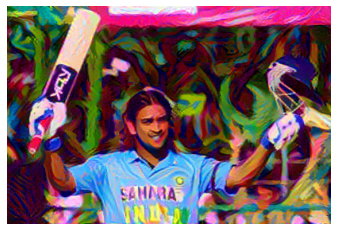

Total loss:  290277.375
Iteration:  2000


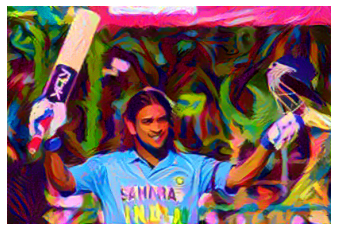

Total loss:  177704.09375
Iteration:  3000


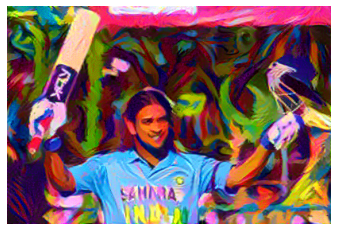

Total loss:  123551.609375
Iteration:  4000


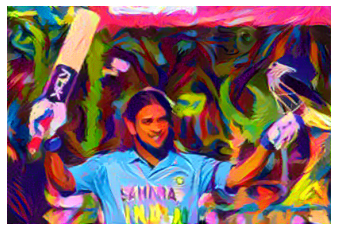

Total loss:  95181.3984375
Iteration:  5000


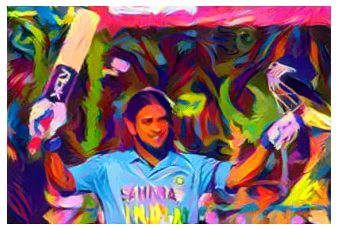

Total loss:  78897.21875
Iteration:  6000


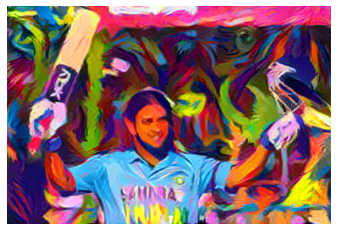

In [ ]:
for ii in range(1, steps+1):
  input_features = get_features(input_image,vgg)
  content_loss = torch.mean((input_features['conv4_2']-content_features['conv4_2'])**2)
  style_loss= 0
  for layer in style_weights:
    input_feature=input_features[layer]
    input_gram = gram_matrix(input_features[layer])
    style_gram = style_grams[layer]
    layer_style_loss = torch.mean((input_gram-style_gram)**2)* style_weights[layer]
    _,d,h,w = input_feature.shape
    style_loss +=layer_style_loss/(d*h*w)

  total_loss = content_loss + style_loss *style_weight

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(input_image))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(input_image)
    counter = counter + 1